# China/PLP trocas comerciais

A partir dos dados da base comtrade das Nações Unidas

## Criar ficheiro de configuração se não existir

O ficheiro de configuração serve para armazenar
a APIKEY que dá acesso a mais de 500 linhas de
resultados.


In [2]:
import os

fname = 'config.ini'
content = """
# Ficheiro de configuração
[comtrade]
# Add API Key. DO NOT SHARE
key = APIKEYHERE
"""
if not os.path.isfile(fname):
  print("Criando ficheiro de configuração")
  with open(fname,'w') as f:
    f.write(content)


## Obter uma chave de acesso à API

Para aceder à UN Comtrade via API sem limites é necessário uma chave de acesso,
de outro modo os resultados são limitados a 500 linhas.

Para obter a chave de acsso:
* Registo em https://comtradedeveloper.un.org/
* Ir para _Products_ 
* Selecionar "Premium Individual APIs" (https://comtradedeveloper.un.org/product#product=dataapis)
* Escolher _Subscribe to "comtrade - v1"_  
* Esperar pelo email com a chave da API key (demora alguns dias
* Copia a chave para o local indicado no ficheiro `config.ini` antes
  de executar o resto do notebook.


In [9]:
import comtrade
import configparser

if os.path.isfile(fname):

    config = configparser.ConfigParser()
    config.read('config.ini')
    APIKEY = config['comtrade']['key']

comtrade.init(APIKEY)

## Parâmetros gerais que não mudam



In [10]:
from comtrade import COUNTRY_CODES_REVERSE as m49

In [12]:
m49_angola = m49['Angola']
m49_brazil = m49['Brazil']
m49_cabo_verde = m49['Cape Verde']
m49_china = m49['China']
m49_hong_kong = m49['China Hong Kong']
m49_macau = m49['China Macau']
m49_guine_equatorial = m49['Equatorial Guinea']
m49_guine_bissau = m49['Guinea-Bissau']
m49_mozambique = m49['Mozambique']
m49_portugal = m49['Portugal']
m49_stome_principe = m49['Sao Tome and Principe']
m49_timor = m49['Timor-Leste']

# make list of Portuguese Speaking Countries
m49_plp = [m49_angola,m49_brazil,m49_cabo_verde,m49_guine_bissau,
            m49_guine_equatorial,m49_mozambique,m49_portugal,
            m49_stome_principe,m49_timor]
m49_plp_list = ",".join(map(str,m49_plp))




## Parâmetros para visualização

Definir as colunas a visualizar, ordem das linhas abaixo para simplificar
posterior visualização dos dados.

### Descrição das colunas 

In [13]:
import comtrade

print(comtrade.COLS_DESC_DF[['Description']].to_markdown())


| COMTRADE+ DATA ITEMS     | Description                                                                              |
|:-------------------------|:-----------------------------------------------------------------------------------------|
| datasetCode              | Combination of several keys to identify specific datasetCode                             |
| typeCode                 | Product type: Goods or Services                                                          |
| freqCode                 | The time interval at which observations occur                                            |
| refPeriodId              | The period of time to which the measured observation is intended to refer                |
| refYear                  | Year of observation                                                                      |
| refMonth                 | Month of observation. For annual, it would bet set to 52                                 |
| period                   | Combination

TODO: isto podia ir para o módulo

In [14]:
cols_all = list(comtrade.COLS_DESC.keys())
cols_basic = ['reporterCode','reporterDesc',
              'partnerCode','partnerDesc',  
              'partner2Code','partner2Desc',  
              'period','flowCode','flowDesc',
              'primaryValue']
sort_order = ['reporterDesc','partnerDesc','period']

## Cobertura dos dados: importações/exportações China-PLP anos disponíveis

In [17]:
import time
import pandas as pd
import comtrade


comtrade.init(APIKEY)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

flow = "M,X"

period = comtrade.year_range(2010,2021)
for country_code in comtrade.PLP_CODES:
    df = comtrade.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=comtrade.m49_china,
                     partnerCode=country_code,
                     partner2Code=0,
                     period=period, # period None returns all the available period
                     apiKey=APIKEY,
                     timeout=60,
                     echo_url=False
                     )
    if df is None:
        print("No data for",comtrade.COUNTRY_CODES[country_code])
    else:
        print(f"{comtrade.COUNTRY_CODES[country_code]},  {df.refYear.unique().min()}-{df.refYear.unique().max()}")
    time.sleep(10)  # avoid stressing the UN server. Increase if Rate limit errors are received


Angola,  2010-2020
Brazil,  2010-2020
Cape Verde,  2010-2020
Equatorial Guinea,  2010-2020
Mozambique,  2010-2020
Portugal,  2010-2020
Guinea-Bissau,  2010-2020
Timor-Leste,  2010-2020
Sao Tome and Principe,  2010-2020


## Directoria para relatórios e gráficos

In [18]:
from pathlib import Path

report_dir = 'reports'
Path(report_dir).mkdir(parents=True, exist_ok=True)

## China e PLP: importações, exportações, volume, saldos

O Forum Macau inclui desde 2016 um quadro sumário
dos dados das trocas comerciais entre a China e 
os PLP. Ver https://www.forumchinaplp.org.mo/pt/publications-data-4/annual-reports/

Esses quadros fornecem o valor das exportações e importação e o 
volume de trocas (importações + exportações). Não calculam o saldo.

Aqui reproduzimos esses quadros a partir das
informações atualmente disponíveis no UN Comtrade,
para todo os anos para os quais existem dados, incluindo o saldo.

>NOTA: Tal como nos quadros do Forum os valores são
apresentados em 10 mil USD

In [32]:
import comtrade


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f} $10mil'.format

year_start = 2010
year_end = 2022
period = comtrade.year_range(year_start,year_end)
flow = "M,X"
plp_codes = list(comtrade.PLP_CODES.keys())
# convert to string
plp_codes = list(map(str,plp_codes))
partnerCode = ",".join(plp_codes)
df = comtrade.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=comtrade.m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     apiKey=APIKEY,
                     timeout=30
                     )

temp=df.pivot(index=['refYear','partnerDesc',],columns='flowCode',values='primaryValue')
temp['C'] = temp['M'] + temp['X']
temp['S'] = temp['X']-temp['M']
forum_type = temp[['C','X','M','S']]
forum_type.columns=['Trocas','Exportações','Importações','Saldo']
forum_type.div(10000).fillna("-")


Trocas         Exportações  \
refYear partnerDesc                                                      
2010    Angola                 2,481,892.20 $10mil   200,387.26 $10mil   
        Brazil                 6,256,009.92 $10mil 2,446,065.19 $10mil   
        Cape Verde                 3,434.72 $10mil     3,433.51 $10mil   
        Equatorial Guinea        105,489.83 $10mil    45,624.12 $10mil   
        Guinea-Bissau              1,329.66 $10mil       943.37 $10mil   
        Mozambique                69,746.86 $10mil    49,639.10 $10mil   
        Portugal                 326,774.37 $10mil   251,331.77 $10mil   
        Sao Tome and Principe        206.47 $10mil       205.43 $10mil   
        Timor-Leste                4,308.25 $10mil     4,283.20 $10mil   
2011    Angola                 2,770,633.39 $10mil   278,415.34 $10mil   
        Brazil                 8,422,342.76 $10mil 3,183,667.73 $10mil   
        Cape Verde                 4,976.37 $10mil     4,975.17 $10mil   
        Equatorial Guinea        193,926.46 $10mil    26,631.71 $10mil   
        Guinea-Bissau              1,896.36 $10mil     1,485.09 $10mil   
        Mozambique                95,748.82 $10mil    70,024.70 $10mil   
        Portugal                 396,349.77 $10mil   280,143.37 $10mil   
        Sao Tome and Principe        179.38 $10mil       179.22 $10mil   
        Timor-Leste                7,217.56 $10mil     7,043.28 $10mil   
2012    Angola                 3,760,106.82 $10mil   403,917.13 $10mil   
        Brazil                 8,569,476.01 $10mil 3,341,363.33 $10mil   
        Cape Verde                 5,749.16 $10mil     5,749.05 $10mil   
        Equatorial Guinea        218,423.75 $10mil    36,143.42 $10mil   
        Guinea-Bissau              2,252.81 $10mil     1,589.46 $10mil   
        Mozambique               134,420.75 $10mil    94,088.70 $10mil   
        Portugal                 401,573.96 $10mil   250,115.76 $10mil   
        Sao Tome and Principe        305.06 $10mil       300.76 $10mil   
        Timor-Leste                6,316.17 $10mil     6,247.35 $10mil   
2013    Angola                 3,593,672.83 $10mil   396,405.89 $10mil   
        Brazil                 9,019,459.39 $10mil 3,589,547.12 $10mil   
        Cape Verde                 6,199.63 $10mil     6,199.61 $10mil   
        Equatorial Guinea        282,743.52 $10mil    35,751.72 $10mil   
        Guinea-Bissau              2,871.73 $10mil     1,188.96 $10mil   
        Mozambique               165,416.80 $10mil   119,929.32 $10mil   
        Portugal                 390,632.45 $10mil   250,686.37 $10mil   
        Sao Tome and Principe        486.45 $10mil       486.20 $10mil   
        Timor-Leste                4,778.34 $10mil     4,738.64 $10mil   
2014    Angola                 3,708,101.19 $10mil   597,499.68 $10mil   
        Brazil                 8,654,335.94 $10mil 3,489,013.45 $10mil   
        Cape Verde                 5,122.65 $10mil     5,122.34 $10mil   
        Equatorial Guinea        356,970.56 $10mil    35,251.53 $10mil   
        Guinea-Bissau              6,710.94 $10mil     1,715.32 $10mil   
        Mozambique               361,856.21 $10mil   196,873.98 $10mil   
        Portugal                 480,036.47 $10mil   313,707.32 $10mil   
        Sao Tome and Principe        572.82 $10mil       572.77 $10mil   
        Timor-Leste                6,044.15 $10mil     6,034.16 $10mil   
2015    Angola                 1,971,875.73 $10mil   371,714.59 $10mil   
        Brazil                 7,150,158.35 $10mil 2,741,222.54 $10mil   
        Cape Verde                 4,332.28 $10mil     4,330.02 $10mil   
        Equatorial Guinea        142,788.64 $10mil    26,138.99 $10mil   
        Guinea-Bissau              3,529.51 $10mil     1,748.27 $10mil   
        Mozambique               239,063.94 $10mil   193,802.34 $10mil   
        Portugal                 435,646.62 $10mil   289,492.31 $10mil   
        Sao Tome and Principe        599.00 $10m

### Gravar em Excel

- [ ] formatar em Excel largura das colunas e formato dos números. Ver cn_plp_commodities.ipynb

In [35]:
real_period = forum_type.index.get_level_values('refYear')
start_year=min(real_period)
end_year=max(real_period)
period=f"{start_year}-{end_year}"
forum_type.to_excel(f"./{report_dir}/quadros_forum_{period}.xlsx")
forum_type.div(10).to_excel(f"./{report_dir}/quadros_forum_10_{period}.xlsx")
forum_type.div(10000).to_excel(f"./{report_dir}/quadros_forum_10mil_{period}.xlsx")

## Gráficos dos valores das importações e exportações, trocas e saldos

### Gráficos das trocas comerciais (importações + exportações)

In [36]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Trocas' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento            Trocas                                   \
Parceiro             Angola             Brazil    Cape Verde   
refYear                                                        
2010      24,818,922,030.00  62,560,099,217.00 34,347,153.00   
2011      27,706,333,858.00  84,223,427,605.00 49,763,747.00   
2012      37,601,068,187.00  85,694,760,113.00 57,491,588.00   
2013      35,936,728,280.00  90,194,593,897.00 61,996,254.00   
2014      37,081,011,865.00  86,543,359,382.00 51,226,457.00   
2015      19,718,757,266.00  71,501,583,488.00 43,322,801.00   
2016      15,646,515,704.00  67,831,200,011.00 48,754,719.00   
2017      22,956,162,692.00  87,807,693,508.00 69,247,880.00   
2018      28,079,647,462.00 111,234,639,172.00 78,556,148.00   
2019      25,893,129,559.00 115,501,610,959.00 64,195,682.00   
2020      16,505,822,542.00 120,470,436,745.00 79,046,671.00   
2021      23,399,776,998.00 163,490,100,674.00 85,684,661.00   

Movimento                                                                    \
Parceiro  Equatorial Guinea Guinea-Bissau       Mozambique         Portugal   
refYear                                                                       
2010       1,054,898,266.00 13,296,570.00   697,468,565.00 3,267,743,710.00   
2011       1,939,264,554.00 18,963,628.00   957,488,225.00 3,963,497,677.00   
2012       2,184,237,487.00 22,528,109.00 1,344,207,513.00 4,015,739,555.00   
2013       2,827,435,191.00 28,717,318.00 1,654,167,987.00 3,906,324,480.00   
2014       3,569,705,576.00 67,109,419.00 3,618,562,147.00 4,800,364,696.00   
2015       1,427,886,383.00 35,295,105.00 2,390,639,408.00 4,356,466,156.00   
2016         780,105,337.00 21,397,687.00 1,787,914,668.00 5,584,937,614.00   
2017       1,650,052,982.00 34,126,721.00 1,835,461,354.00 5,584,393,468.00   
2018       2,284,518,497.00 37,470,387.00 2,495,314,478.00 5,999,253,728.00   
2019       1,836,268,508.00 40,341,038.00 2,670,936,644.00 6,688,752,834.00   
2020       1,304,669,441.00 51,436,017.00 2,579,567,171.00 6,953,053,417.00   
2021       1,339,126,559.00 88,880,025.00 4,036,732,373.00 8,808,028,463.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2010               2,064,686.00  43,082,495.00  
2011               1,793,809.00  72,175,553.00  
2012               3,050,638.00  63,161,676.00  
2013               4,864,493.00  47,783,404.00  
2014               5,728,191.00  60,441,499.00  
2015               5,989,950.00 105,254,503.00  
2016               6,422,213.00 164,564,406.00  
2017               6,902,568.00 134,169,790.00  
2018               7,304,349.00 135,404,120.00  
2019               8,934,279.00 167,513,087.00  
2020              20,360,128.00 192,483,012.00  
2021              15,077,312.00 373,584,568.00

/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_15603/3571032375.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


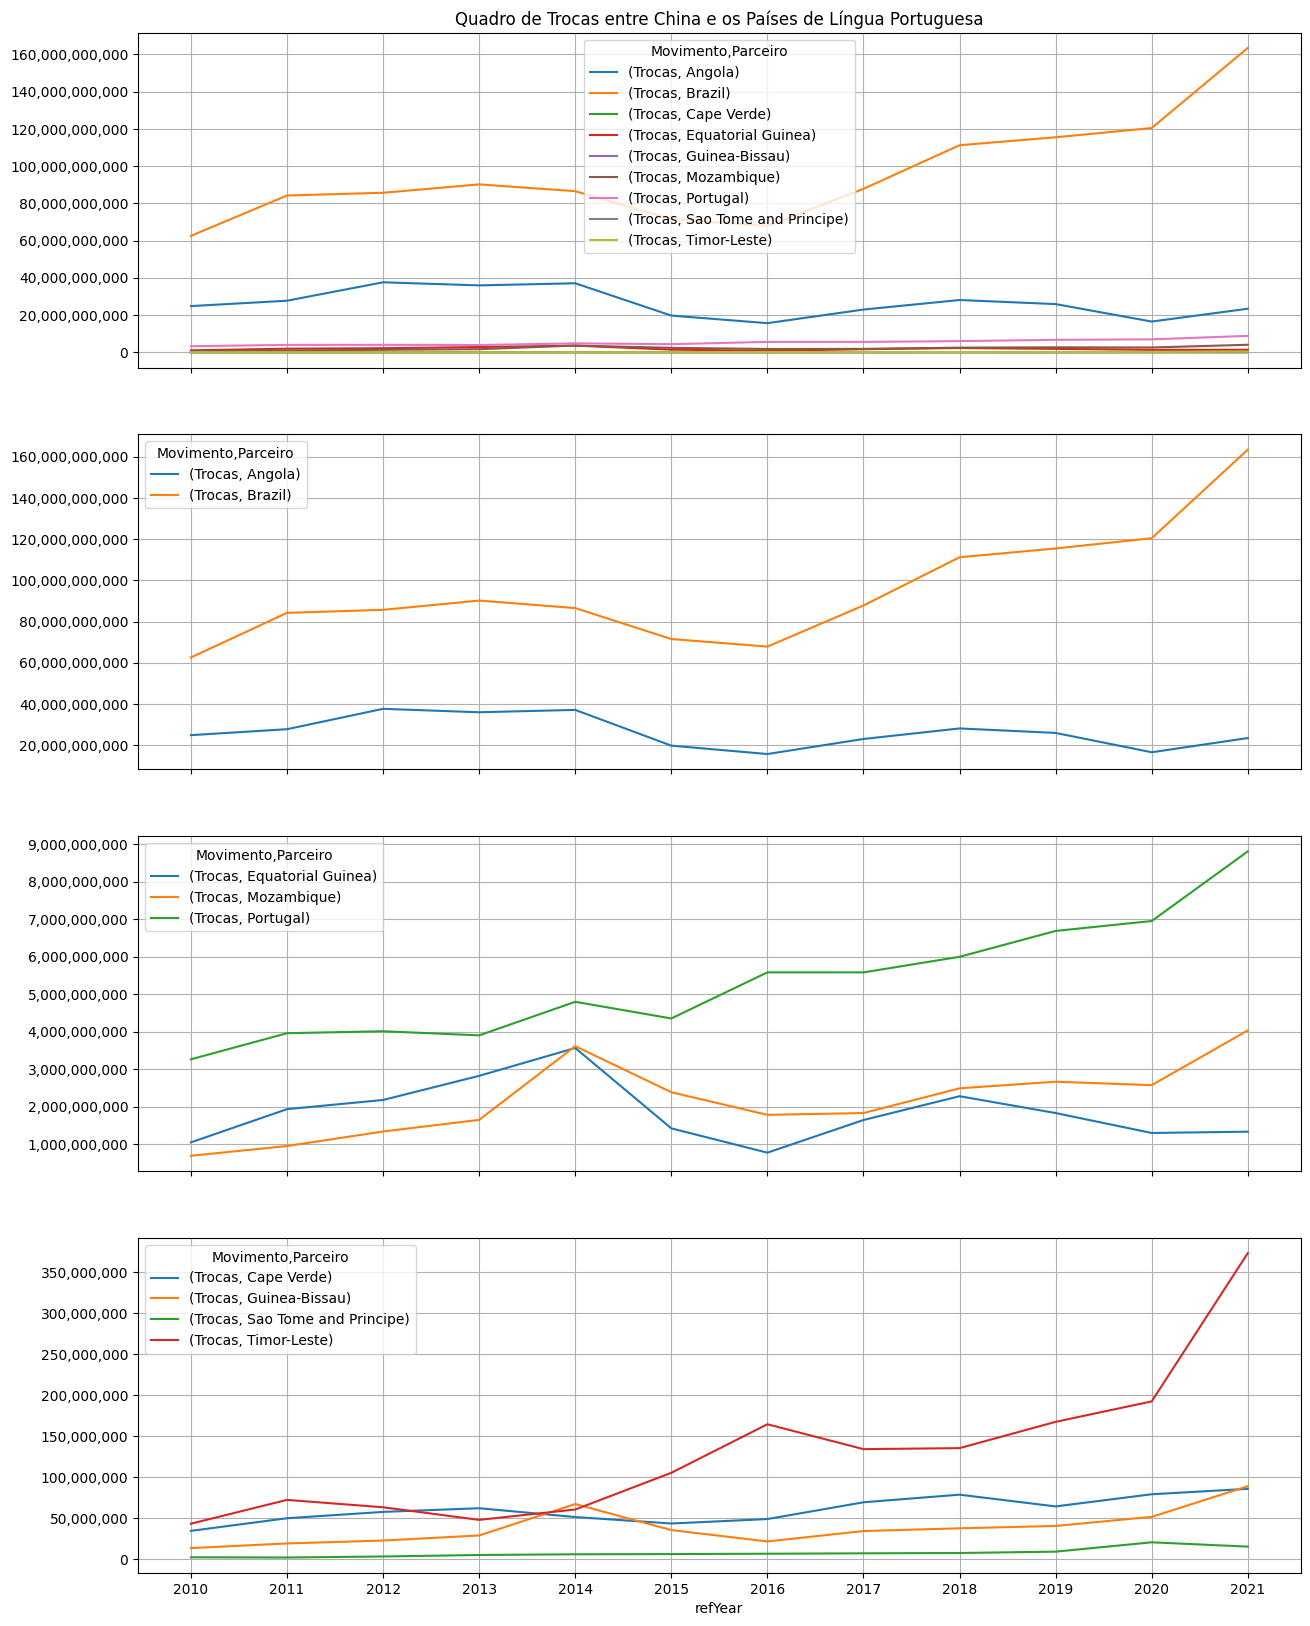

In [37]:
import matplotlib.pyplot as plt
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} entre {country[m49_china]} e os Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=True,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos importações

In [38]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Importações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento       Importações                                                    \
Parceiro             Angola             Brazil   Cape Verde Equatorial Guinea   
refYear                                                                         
2010      22,815,049,454.00  38,099,447,351.00    12,060.00    598,657,025.00   
2011      24,922,180,492.00  52,386,750,280.00    12,062.00  1,672,947,440.00   
2012      33,561,896,917.00  52,281,126,771.00     1,115.00  1,822,803,333.00   
2013      31,972,669,347.00  54,299,122,653.00       160.00  2,469,917,950.00   
2014      31,106,015,046.00  51,653,224,893.00     3,020.00  3,217,190,248.00   
2015      16,001,611,383.00  44,089,358,062.00    22,606.00  1,166,496,464.00   
2016      13,966,117,080.00  45,855,047,246.00    83,281.00    631,851,506.00   
2017      20,698,709,467.00  58,857,155,273.00     8,010.00  1,483,835,026.00   
2018      25,826,510,355.00  77,569,499,985.00   290,397.00  2,139,372,096.00   
2019      23,837,402,142.00  79,962,547,047.00    28,691.00  1,723,064,057.00   
2020      14,757,730,338.00  85,517,209,220.00 1,209,992.00  1,182,549,225.00   
2021      20,908,231,317.00 109,877,876,281.00 1,146,922.00  1,215,142,465.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
2010       3,862,870.00   201,077,529.00   754,426,018.00   
2011       4,112,691.00   257,241,199.00 1,162,063,935.00   
2012       6,633,460.00   403,320,479.00 1,514,582,001.00   
2013      16,827,743.00   454,874,745.00 1,399,460,781.00   
2014      49,956,236.00 1,649,822,358.00 1,663,291,480.00   
2015      17,812,428.00   452,616,050.00 1,461,543,018.00   
2016         161,227.00   479,356,871.00 1,582,818,088.00   
2017         402,375.00   528,715,219.00 2,139,178,524.00   
2018       7,638,682.00   633,533,508.00 2,249,055,585.00   
2019       8,402,360.00   713,241,603.00 2,322,314,576.00   
2020           5,381.00   579,498,619.00 2,772,488,349.00   
2021           1,111.00 1,141,126,932.00 3,453,790,380.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2010                  10,397.00     250,487.00  
2011                   1,639.00   1,742,791.00  
2012                  43,026.00     688,156.00  
2013                   2,464.00     397,037.00  
2014                     474.00      99,850.00  
2015                  33,209.00     724,858.00  
2016                  17,722.00     291,606.00  
2017                     710.00   1,573,168.00  
2018                  49,225.00   3,014,403.00  
2019                  13,720.00  24,564,329.00  
2020                  46,656.00   1,210,615.00  
2021                 132,797.00 113,151,289.00

/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_15603/593253419.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


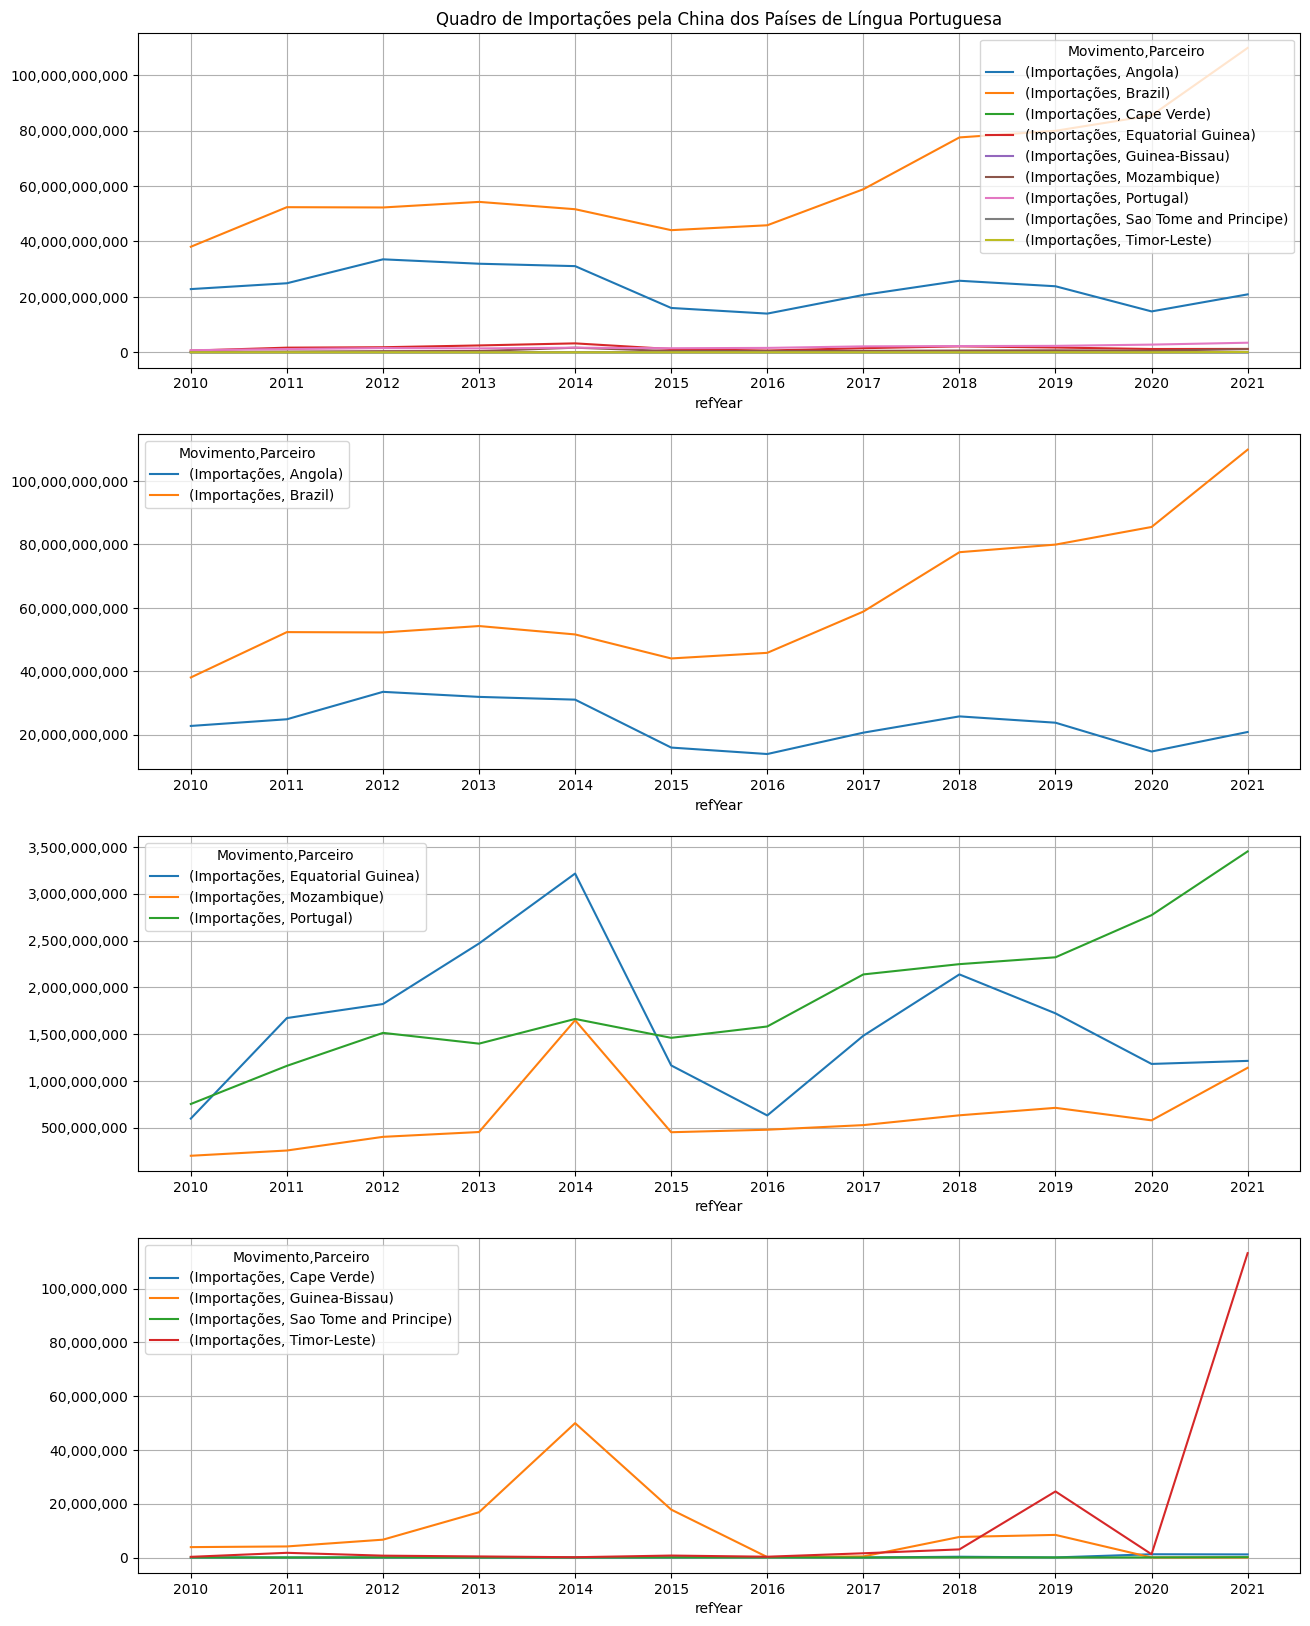

In [39]:
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} pela {country[m49_china]} dos Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos exportações

In [15]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Exportações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento      Exportações                                                    \
Parceiro            Angola            Brazil    Cape Verde Equatorial Guinea   
refYear                                                                        
1992          8,472,850.00     64,751,735.00    161,485.00        180,825.00   
1993         11,206,948.00    192,166,216.00    754,935.00        635,394.00   
1994         12,482,005.00    362,390,910.00    424,394.00        584,829.00   
1995         21,159,336.00    759,058,693.00    380,342.00      2,330,370.00   
1996         28,533,705.00    762,930,545.00    274,927.00      5,970,663.00   
1997         29,128,511.00  1,044,389,298.00    405,394.00      3,335,113.00   
1998         36,653,028.00  1,085,363,968.00  1,960,845.00      2,937,185.00   
1999         16,363,697.00    876,002,206.00  3,141,087.00      2,497,962.00   
2000         33,735,509.00  1,223,545,495.00  5,178,211.00      3,549,061.00   
2001         45,721,834.00  1,350,925,018.00  2,212,932.00      3,354,587.00   
2002         61,310,901.00  1,466,382,340.00  1,839,369.00      3,287,681.00   
2003        145,791,215.00  2,143,255,914.00  2,596,097.00      5,048,022.00   
2004        193,517,905.00  3,674,104,212.00  2,746,211.00     10,124,623.00   
2005        372,793,946.00  4,827,209,396.00  5,187,788.00     18,801,431.00   
2006        894,185,633.00  7,380,105,731.00 10,094,090.00     41,107,988.00   
2007      1,234,518,651.00 11,398,472,406.00 16,826,488.00     92,790,802.00   
2008      2,942,469,756.00 18,807,457,292.00 14,953,954.00    277,390,904.00   
2009      2,385,960,008.00 14,118,518,263.00 35,405,032.00    358,423,820.00   
2010      2,003,872,576.00 24,460,651,866.00 34,335,093.00    456,241,241.00   
2011      2,784,153,366.00 31,836,677,325.00 49,751,685.00    266,317,114.00   
2012      4,039,171,270.00 33,413,633,342.00 57,490,473.00    361,434,154.00   
2013      3,964,058,933.00 35,895,471,244.00 61,996,094.00    357,517,241.00   
2014      5,974,996,819.00 34,890,134,489.00 51,223,437.00    352,515,328.00   
2015      3,717,145,883.00 27,412,225,426.00 43,300,195.00    261,389,919.00   
2016      1,680,398,624.00 21,976,152,765.00 48,671,438.00    148,253,831.00   
2017      2,257,453,225.00 28,950,538,235.00 69,239,870.00    166,217,956.00   
2018      2,253,137,107.00 33,665,139,187.00 78,265,751.00    145,146,401.00   
2019      2,055,727,417.00 35,539,063,912.00 64,166,991.00    113,204,451.00   
2020      1,748,092,204.00 34,953,227,525.00 77,836,679.00    122,120,216.00   
2021      2,491,545,681.00 53,612,224,393.00 84,537,739.00    123,984,094.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
1992       2,401,586.00    20,729,009.00    43,992,562.00   
1993       2,716,341.00    16,548,204.00    73,928,694.00   
1994       4,002,964.00     6,518,220.00    74,517,509.00   
1995       1,090,892.00    11,523,079.00   106,053,862.00   
1996         462,599.00    11,235,225.00   133,797,930.00   
1997         722,255.00    15,941,226.00   166,149,804.00   
1998       1,452,681.00    13,333,985.00   200,589,600.00   
1999       3,181,137.00    18,931,038.00   219,943,236.00   
2000       4,621,401.00    24,706,053.00   260,823,590.00   
2001       8,299,380.00    22,041,054.00   260,568,014.00   
2002       4,503,979.00    25,931,947.00   300,879,648.00   
2003      12,350,232.00    45,028,314.00   406,256,461.00   
2004       5,994,304.00    75,154,316.00   588,259,140.00   
2005       5,793,889.00    91,477,874.00   911,952,506.00   
2006       5,677,056.00   127,940,363.00 1,359,664,205.00   
2007       7,308,823.00   163,552,940.00 1,834,752,144.00   
2008       6,146,998.00   295,994,949.00 2,317,102,263.00   
2009      23,193,644.00   339,133,810.00 1,923,516,206.00   
2010       9,433,700.00   496,391,036.00 2,513,317,692.00   
2011      14,850,

/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_15603/1921030421.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


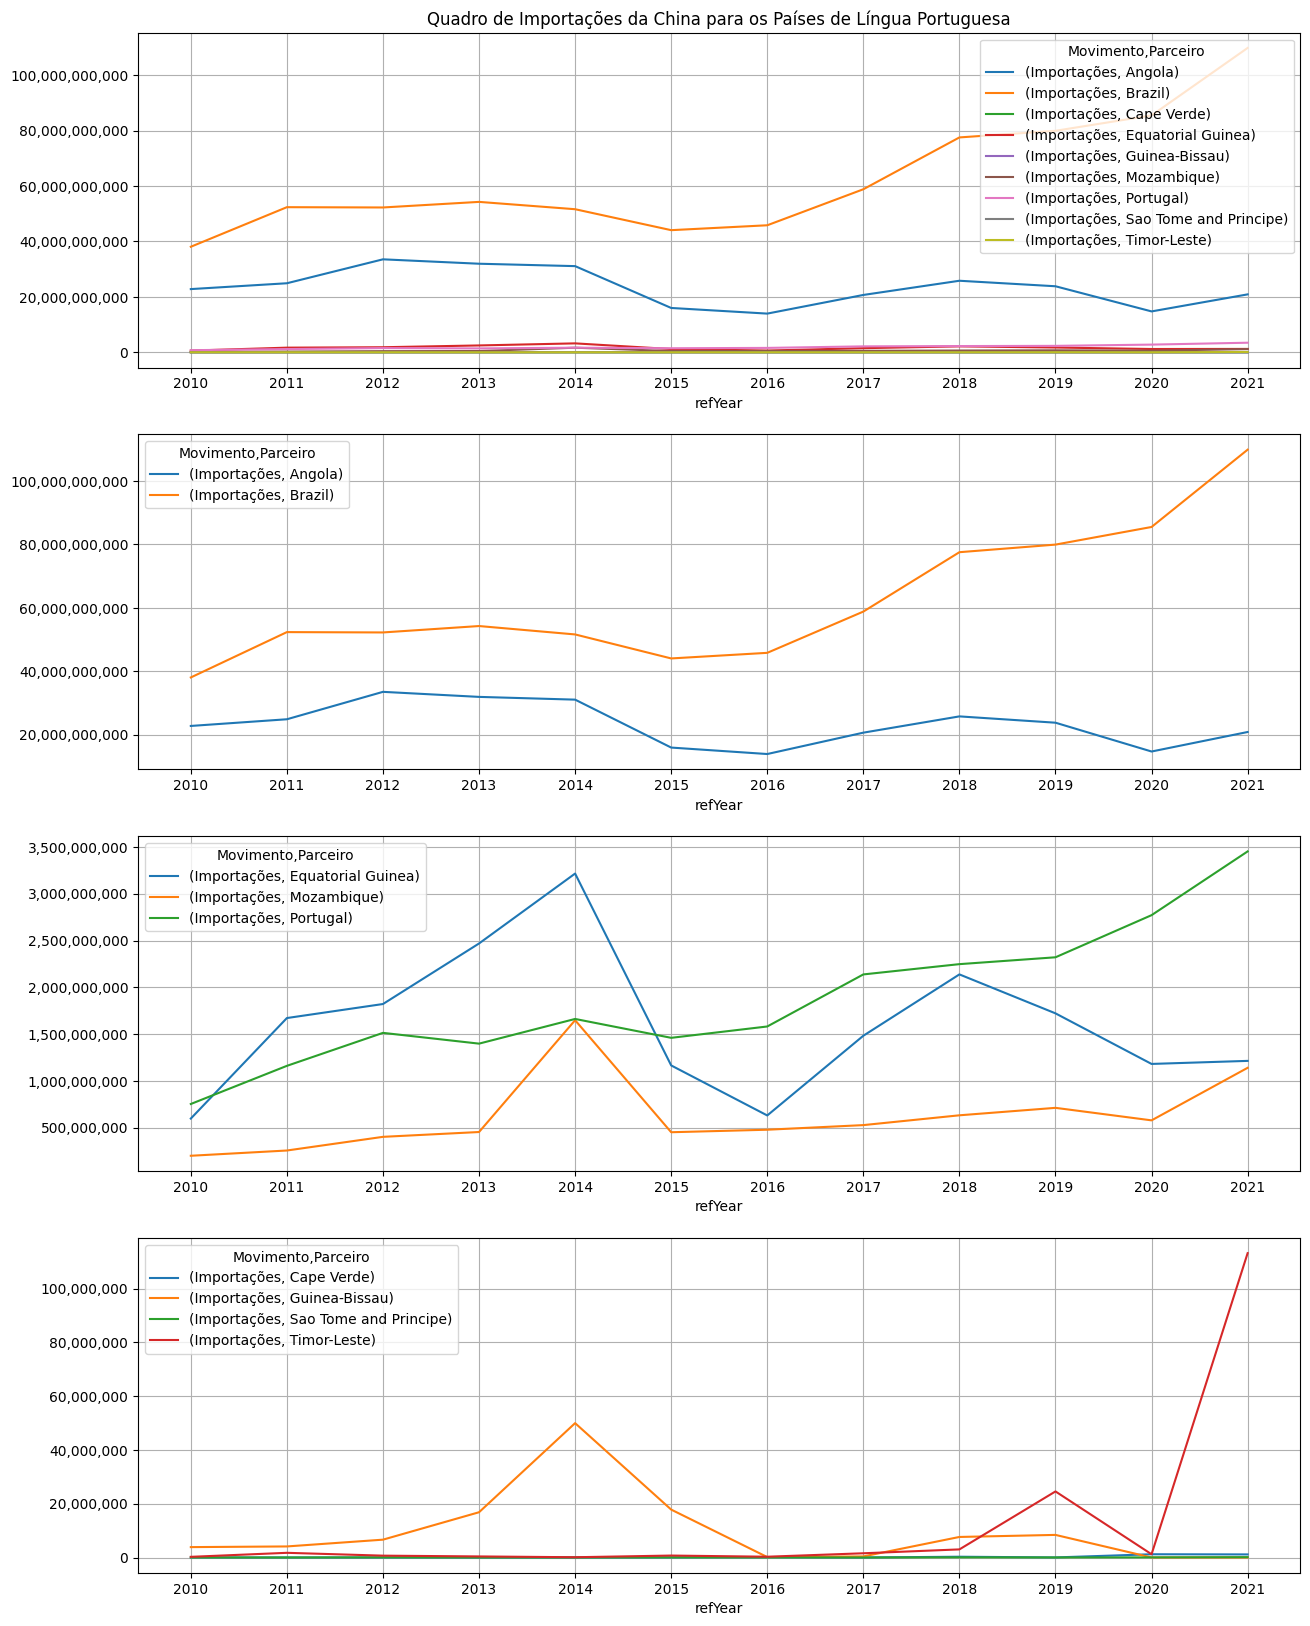

In [40]:
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} da {country[m49_china]} para os Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos saldo (China: exportações-importações)

In [41]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Saldo' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento              Saldo                                   \
Parceiro              Angola             Brazil    Cape Verde   
refYear                                                         
2010      -20,811,176,878.00 -13,638,795,485.00 34,323,033.00   
2011      -22,138,027,126.00 -20,550,072,955.00 49,739,623.00   
2012      -29,522,725,647.00 -18,867,493,429.00 57,489,358.00   
2013      -28,008,610,414.00 -18,403,651,409.00 61,995,934.00   
2014      -25,131,018,227.00 -16,763,090,404.00 51,220,417.00   
2015      -12,284,465,500.00 -16,677,132,636.00 43,277,589.00   
2016      -12,285,718,456.00 -23,878,894,481.00 48,588,157.00   
2017      -18,441,256,242.00 -29,906,617,038.00 69,231,860.00   
2018      -23,573,373,248.00 -43,904,360,798.00 77,975,354.00   
2019      -21,781,674,725.00 -44,423,483,135.00 64,138,300.00   
2020      -13,009,638,134.00 -50,563,981,695.00 76,626,687.00   
2021      -18,416,685,636.00 -56,265,651,888.00 83,390,817.00   

Movimento                                                                     \
Parceiro  Equatorial Guinea  Guinea-Bissau       Mozambique         Portugal   
refYear                                                                        
2010        -142,415,784.00   5,570,830.00   295,313,507.00 1,758,891,674.00   
2011      -1,406,630,326.00  10,738,246.00   443,005,827.00 1,639,369,807.00   
2012      -1,461,369,179.00   9,261,189.00   537,566,555.00   986,575,553.00   
2013      -2,112,400,709.00  -4,938,168.00   744,418,497.00 1,107,402,918.00   
2014      -2,864,674,920.00 -32,803,053.00   318,917,431.00 1,473,781,736.00   
2015        -905,106,545.00    -329,751.00 1,485,407,308.00 1,433,380,120.00   
2016        -483,597,675.00  21,075,233.00   829,200,926.00 2,419,301,438.00   
2017      -1,317,617,070.00  33,321,971.00   778,030,916.00 1,306,036,420.00   
2018      -1,994,225,695.00  22,193,023.00 1,228,247,462.00 1,501,142,558.00   
2019      -1,609,859,606.00  23,536,318.00 1,244,453,438.00 2,044,123,682.00   
2020      -1,060,429,009.00  51,425,255.00 1,420,569,933.00 1,408,076,719.00   
2021      -1,091,158,371.00  88,877,803.00 1,754,478,509.00 1,900,447,703.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2010               2,043,892.00  42,581,521.00  
2011               1,790,531.00  68,689,971.00  
2012               2,964,586.00  61,785,364.00  
2013               4,859,565.00  46,989,330.00  
2014               5,727,243.00  60,241,799.00  
2015               5,923,532.00 103,804,787.00  
2016               6,386,769.00 163,981,194.00  
2017               6,901,148.00 131,023,454.00  
2018               7,205,899.00 129,375,314.00  
2019               8,906,839.00 118,384,429.00  
2020              20,266,816.00 190,061,782.00  
2021              14,811,718.00 147,281,990.00

/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_15603/2146500004.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


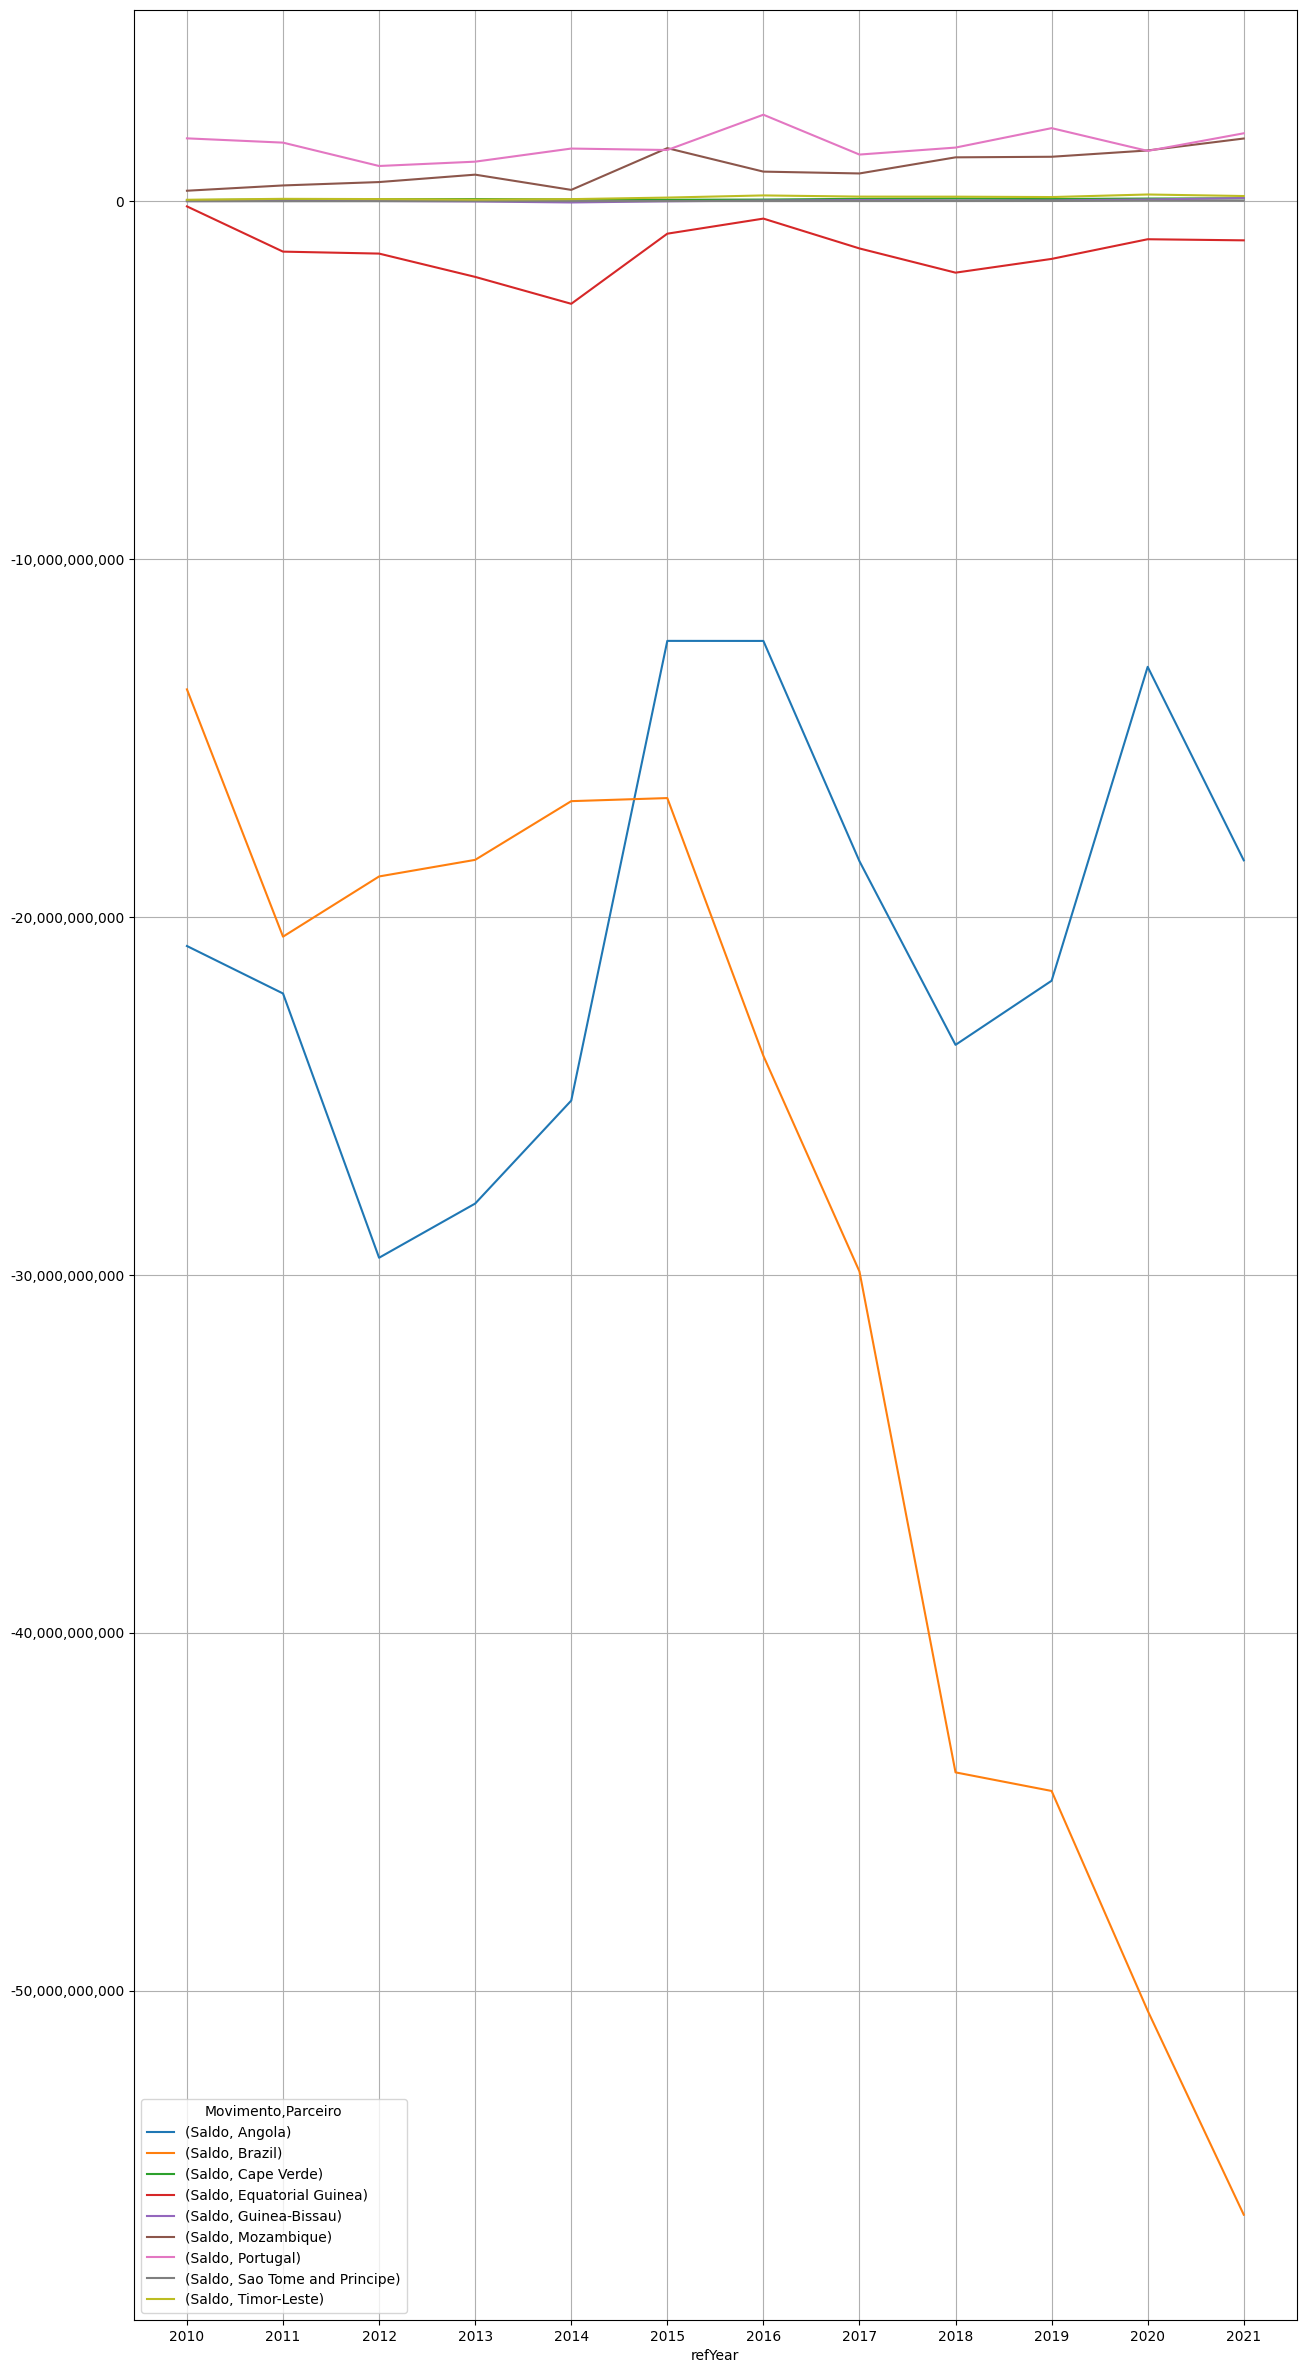

In [42]:
import matplotlib.pyplot as plt
ax = graph_data.plot.line(figsize=(15,30),xticks=graph_data.index.values)

current_values = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
ax.grid()
plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

In [43]:
import datetime
# print the current date and time


print("Current date and time: ", datetime.datetime.now())

Current date and time:  2023-06-12 16:01:00.222325
